In [1]:
Threads.nthreads()
begin
    using LinearAlgebra 
    using Plots
    using FFTW
    using FileIO
    using JLD2
    using DiffEqFlux
    using OrdinaryDiffEq
    using BlockArrays
    using LaTeXStrings
    using SparseArrays
    using BSON
    using Distances
    using DifferentialEquations
    using Optimization
    using OptimizationPolyalgorithms
    using Zygote
    using OptimizationOptimJL
    using OptimizationOptimisers
    using DiffEqSensitivity
    using DelimitedFiles
    using HDF5
    using Plots
    using InvertedIndices
    using Random
    using Statistics
    using LineSearches
    using CSV
    using DataFrames
end 

In [84]:
filename = "/home/tschala/research/LANL/case1_1_1D_waveforms_results.h5"
file = h5open(filename, "r")
# Read the dataset
data1d = read(file["data"])

# Close the file
close(file)

In [85]:
println("Size of 1D data matrix:",size(data1d))
println("Shape: [timesteps,spatial locations,waveforms,variables]")

# note that some elements in space a duplicate
# the real spatial size is 100

Size of 1D data matrix:(300, 110, 47, 4)
Shape: [timesteps,spatial locations,waveforms,variables]


In [86]:
# remove duplicate data (both ends of a segment are saved)
data1d_fix = data1d[200:end,Not(11:11:end),:,:];
# remove the unphysical peaks, just replace with linear interpolation
data1d_fix[:,41,:,1] = (data1d_fix[:,40,:,1] + data1d_fix[:,42,:,1])/2;
data1d_fix[:,61,:,1] = (data1d_fix[:,60,:,1] + data1d_fix[:,62,:,1])/2;

In [87]:
begin
    global dz = 0.04                     # x step
    global T = 1.0                   # total time
    global L = 3.96                   # total length
    global zspan = (0,L)                 # end points of time integration for ODEProbem
    global dt = 0.01                   #time step
    global train_maxiters = 5         # number of iterations of learning
    global learning_rate  = 0.01         # learning rate , currently using PolyOpt default (0.1)


end

0.01

In [88]:
path_to_working_directory="/home/tschala/research/LANL/juliaDiffProgExample/"

include("$path_to_working_directory/src/numerical_derivatives.jl");
include("$path_to_working_directory/src/train_utils.jl");

In [89]:
#first order derivatives
∂t1_center = f1_secondOrder_central(101,dt);
∂t1_forward = f1_secondOrder_forward(101,dt);
∂t1_backward = f1_secondOrder_backward(101,dt);

# use central difference for the majority
∂t1 = ∂t1_center
# use forward and backward difference near the boundaries
∂t1[1,:]=∂t1_forward[1,:]
∂t1[end,:] = ∂t1_backward[end,:]

101-element SparseVector{Float64, Int64} with 3 stored entries:
  [99 ]  =  50.0
  [100]  =  -200.0
  [101]  =  150.0

In [90]:
#waveforms to use
waveforms = 30


# Set the seed for reproducibility
Random.seed!(123)

# # # Shuffle the indices of the vector
# shuffled_indices = randperm(size(data1d_fix)[3])

# # # Divide the shuffled indices into training and test sets
# train_indices = shuffled_indices[1:waveforms];
# test_indices = shuffled_indices[waveforms+1:end];

# Shuffle the indices of the vector
shuffled_indices = 1:47

# Divide the shuffled indices into training and test sets
train_indices = [shuffled_indices[7:24];shuffled_indices[31:41]];
test_indices = shuffled_indices[25:30];
test_indices_ex = [shuffled_indices[1:6];shuffled_indices[42:end]];

In [91]:
# select field variable ID
# 1 - flow rate, 2 - pressure, 3 - area, 4 - Wall Shear Stress
pID = 1

1

In [92]:
#define IC's
u0 = data1d_fix[1,1:end,train_indices,pID];
u01 = data1d_fix[1,1:end,1,pID];

u0_test = data1d_fix[1,1:end,test_indices,pID];
u0_ex = data1d_fix[1,1:end,test_indices_ex,pID];

#ground truth data
ytrain2 = data1d_fix[:,1:end,train_indices,pID];
ytrain21 = data1d_fix[:,1:end,1,pID];

ytest2 = data1d_fix[:,1:end,test_indices,pID];
yex2 = data1d_fix[:,1:end,test_indices_ex,pID];

#boundary conditions
bc_flow = data1d_fix[:,1,train_indices,pID];
bc_flow1 = bc_flow[:,1];

bc_flow_test = data1d_fix[:,1,test_indices,pID];
bc_flow_ex  = data1d_fix[:,1,test_indices_ex,pID];

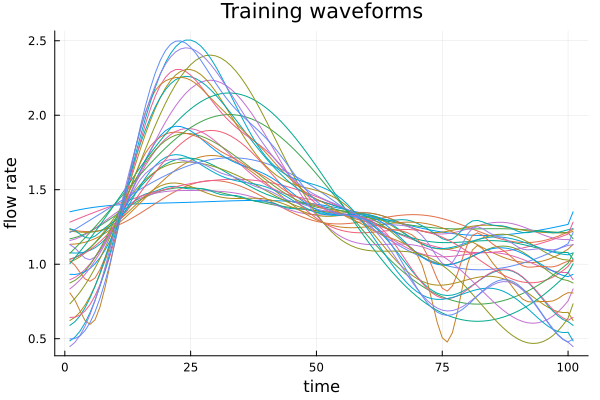

In [93]:
plot(bc_flow, legend = false)
xlabel!("time")
ylabel!("flow rate")
title!("Training waveforms")

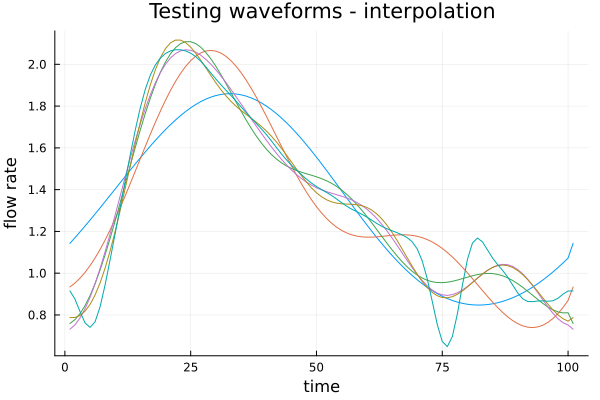

In [94]:
plot(bc_flow_test, legend = false)
xlabel!("time")
ylabel!("flow rate")
title!("Testing waveforms - interpolation")

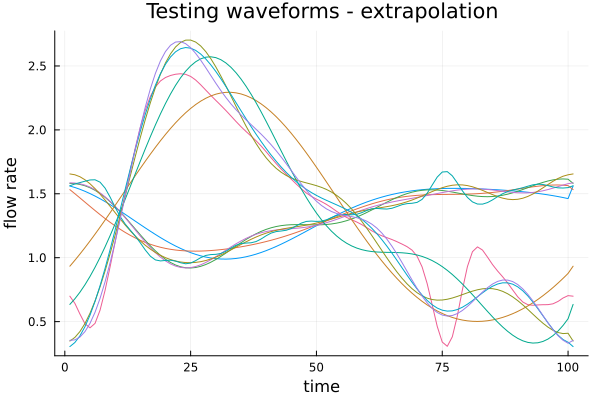

In [95]:
plot(bc_flow_ex, legend = false)
xlabel!("time")
ylabel!("flow rate")
title!("Testing waveforms - extrapolation")

In [96]:
Nspace = size(u01,1)   # number of points in space
x = 0.0 : dz : L        # discretized spatial dimension 

# finite-difference schemes

#first order derivatives
∂x1_center = f1_secondOrder_central(Nspace,dz);
∂x1_forward = f1_secondOrder_forward(Nspace,dz);
∂x1_backward = f1_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x1 = ∂x1_center
# use forward and backward difference near the boundaries
∂x1[1,:]=∂x1_forward[1,:]
∂x1[end,:] = ∂x1_backward[end,:]

#second order derivatives
∂x2_center = f2_secondOrder_central(Nspace,dz);
∂x2_forward = f2_secondOrder_forward(Nspace,dz);
∂x2_backward = f2_secondOrder_backward(Nspace,dz);

# use central difference for the majority
∂x2 = ∂x2_center;
# use forward and backward difference near the boundaries
∂x2[1,:]=∂x2_forward[1,:];
∂x2[end,:] = ∂x2_backward[end,:];

In [97]:
aID = 3
#ground truth data for area
Atrain = data1d_fix[:,1:end,train_indices,aID];
Atrain1 = data1d_fix[:,1:end,1,aID];

Atest = data1d_fix[:,1:end,test_indices,aID];
Aex = data1d_fix[:,1:end,test_indices_ex,aID];

In [98]:
# calculate derivative of area with respect to space
dAdz = zero(Atrain)
dAdz_test = zero(Atest)
dAdz_ex = zero(Aex)
for i in 1:size(Atrain)[1]
    dAdz[i,:,:] = ∂x1 * Atrain[i,:,:]
    dAdz_test[i,:,:] = ∂x1 * Atest[i,:,:]
    dAdz_ex[i,:,:] = ∂x1 * Aex[i,:,:]
end

#plot area for first simulation/waveform
# h1 = heatmap(Atrain[:,:,1]')
# xlabel!("time")
# ylabel!("space")
# title!("Area - A")
# display(h1)

# heatmap(dAdz[:,:,1]')
# xlabel!("time")
# ylabel!("space")
# title!("dA/dz")

In [99]:
N = size(bc_flow1,1)
# NN embedded in PDE for Differential programming
# Define the network architecture with initialization
hidden_dim = 10

ann = Chain(
    Dense(N, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, hidden_dim, tanh, init = Flux.glorot_uniform),
    Dense(hidden_dim, N, init = Flux.glorot_uniform)
)

Chain(
  Dense(101 => 10, tanh),               # 1_020 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 10, tanh),                # 110 parameters
  Dense(10 => 101),                     # 1_111 parameters
)                   # Total: 8 arrays, 2_351 parameters, 9.684 KiB.

In [100]:
# flatten parameters in NN for learning.                
p, re = Flux.destructure(ann);
ps = deepcopy(p)
p_size = size(p,1);
println("Number of parameters in neural network: $p_size"); 

Number of parameters in neural network: 2351


In [101]:
# # Define time-dependent variables
function interpolate_variables(t, vector)
    # t - dependent variable, could be time or space (z) too
    #      if t is time then use dt, if it's space use dz, same with T <--> L
    # vector - data vector with values at distinct t locations
    #
    # This function interpolates values such that we can access the values from vector
    # not just at the original data points but anywhere in between
    

    # Find the two closest points in vector
    #caculate the time index that's closest to time t

    t_index = Int(floor(t / dz)) + 1

    # calculate local time fraction between the grid points
    t_frac = (t - (t_index - 1) * dz) / dz

    # Perform linear interpolation between data points in vector
    # if we are at the last timesteps just copy the value cause t_index+1 will not exist
    if t == L
        vector_interp = vector[:,:,t_index]
        
    else
        vector_interp = (1 - t_frac) * vector[:,:,t_index] + t_frac * vector[:,:,t_index + 1]
    end
    
    # return the interpolated value of vector at time(space) = t
    return vector_interp
end


# # Define time-dependent boundary condition function
interp_func(z) = interpolate_variables(z, atrain)


interp_func (generic function with 1 method)

In [102]:
# parabolic flow profile constant
# https://simvascular.github.io/docs1DSimulation.html#solver
δ = 1/3;
# viscosity in CGS units
ν = 0.04;
# velocity profile constant
Nprof = -8*π*ν;

In [103]:
function learn_1DBlood(u, p, z, interp_func, dadz_interp_func)
    # u - input to neural network, field variable we are solving for (flow rate)
    # p - neural network parameters
    # z - dependent variable (z -space, or t - time)
    # interp_func - area values for interpolation as a function of z
    # dadz_interp_func - dA/dz values for interpolation as a function of z
    
    
    Φ = re(p)  # restructure flattened parameter vector into NN architecture.
    

    #concatenate u and the BC as input to the NN
#     input = vcat(u)
    
    # add some physics term to the right-hand-side
    # 1/2*Q/A*dA/dz + N/(2*(1+δ))
    
    #
    #.+ 1/2 .* u ./ interp_func(z) .* dadz_interp_func(z) .+ Nprof/(2*(1+δ))
    #.-1/(2*(1+δ)) .* interp_func(z) ./ u .* (∂t1 * u) 
    
#     println("space z: ", z)
#     println("term 1: 1/2*Q/S*dS/dz ", sum(1/2 .* u ./ interp_func(z) .* dadz_interp_func(z)))
#     println("term 2 N/2(1+delta): ", sum(Nprof/(2*(1+δ))))
#     println("term 3 -1/2(1+d)*S/Q*dQ/dt: ", sum(-1/(2*(1+δ)) .* interp_func(z) ./ u .* (∂t1 * u)))
#     println("Mean area S: ", mean(interp_func(z)), "size S: ", size(interp_func(z)))
#     println("Mean area dS/dz: ", mean(dadz_interp_func(z)))
#     println("Mean Previous flow rate Q:", mean(u), ", std Q:", std(u), "size Q: ", size(u))
#     println("Mean Q/S:", mean(u ./ interp_func(z)))
#     println("Mean S/Q:", mean(interp_func(z) ./ u))
#     println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
#     flush(stdout)
    
#     plotQ = plot(u)
#     display(plot(plotQ))
#     sleep(1)
    
    return Φ(u)
end

# #define learning problem.
learn_1DBlood_prob(u01,zspan) =  ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, bc_left_func,dadz_interp_func), u01, zspan, p)

learn_1DBlood_prob (generic function with 1 method)

In [104]:
ode_solver = "Tsit5"
output_dir = "/home/tschala/research/LANL/dQdz_physics_testNODE"
working_dir = output_dir


prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z,bc_left_func,dadz_interp_func), bc_flow1, zspan, p) ;
function predict(θ,prob)
    if ode_solver == "Tsit5"
        Array(solve(prob,Tsit5(),p=θ,dt=dz,saveat=dz,adaptive=true))
    elseif ode_solver == "RK4"
        Array(solve(prob,RK4(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff]))
    elseif ode_solver == "Rosenbrock23"
        Array(solve(prob,Rosenbrock23(),p=θ,dt=dz/10,saveat=dz,adaptive=false,alg_hints=[:stiff]))
    end
end 

predict (generic function with 1 method)

In [105]:
function loss(θ, ytrain21, prob)
    pred = predict(θ, prob)

    
    l = sum(abs2,(pred - ytrain21))# + 0.0*dudt #  + 1e-3*sum(abs.(θ)) #add regularization
    return l, pred
end


# l , pred = loss(ps,ytrain21,prob)

# training optimizer definition
adtype = Optimization.AutoZygote() ;
optf = Optimization.OptimizationFunction((x,p)->loss(x,ytrain21,prob),adtype) ;

In [106]:
path_checkpoint=nothing
optimizer_choice1 = "ADAM"
optimizer_choice2 = "BFGS"

"BFGS"

In [107]:
# process user choices

if !isdir(working_dir)
    mkdir(working_dir)
end
output_dir = working_dir*"/output/"
cd(working_dir) #switch to working directory
if !isdir(output_dir)
    mkdir(output_dir)
end
println("optimizer 1 is $optimizer_choice1")
if !isnothing(optimizer_choice2)
    println("optimizer 2 is $optimizer_choice2 optimizer")
end

println("ODE Time integrator selected:", ode_solver)


optimizer 1 is ADAM
optimizer 2 is BFGS optimizer
ODE Time integrator selected:Tsit5


In [108]:
L = 3.96  # total length
zspan = (0.0, L)
println(zspan)
tsteps = 0:dz:zspan[2]  # create time vector

#set batch size
batch_size = 10
println("Batch size:", batch_size)
#training batches
batch_iterations = Int(ceil(size(ytrain2,3)/batch_size))
#testing batches
test_batch_iterations = Int(ceil(size(ytest2,3)/batch_size));
ex_batch_iterations = Int(ceil(size(yex2,3)/batch_size));

(0.0, 3.96)
Batch size:10


waveform batch: 1/3
rel train error batch:0.003614469711100725
train 1


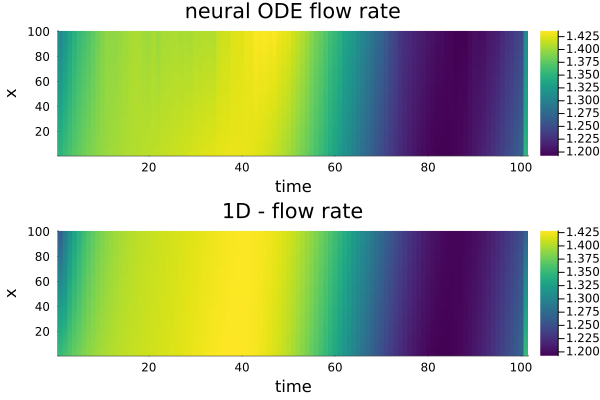

train 2


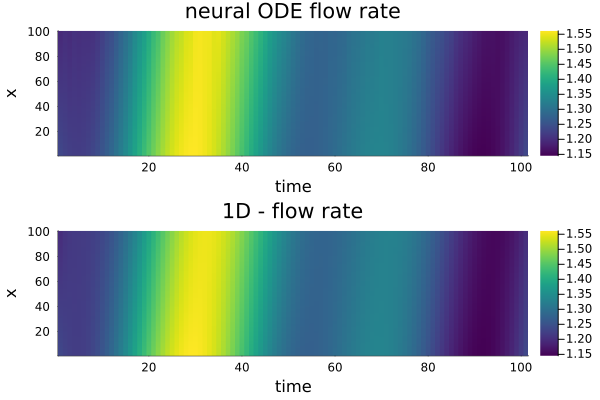

train 3


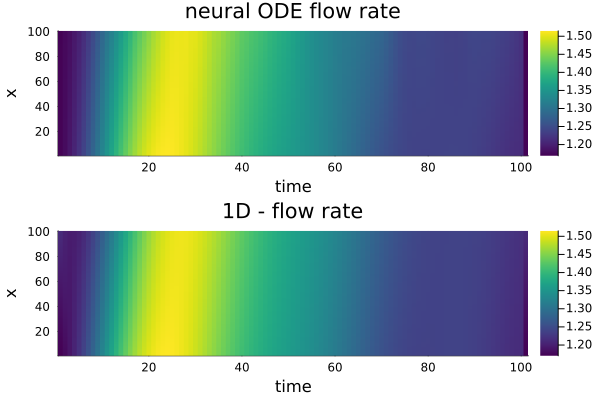

train 4


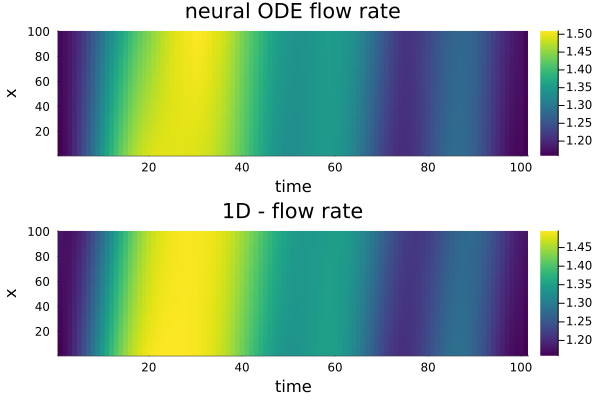

train 5


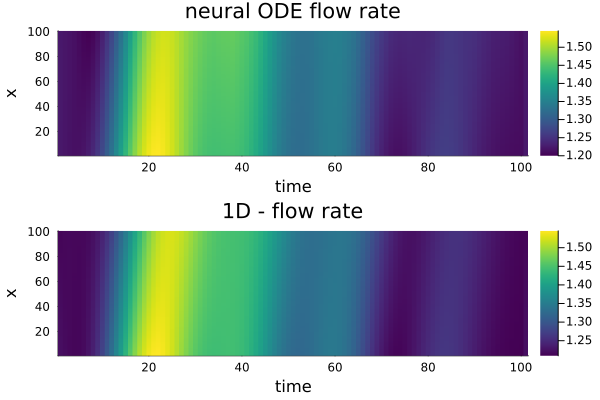

train 6


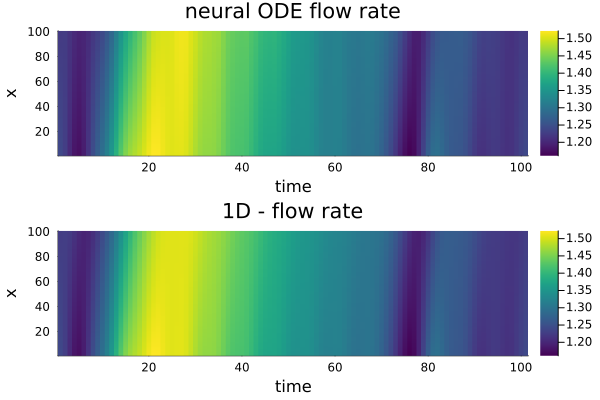

train 7


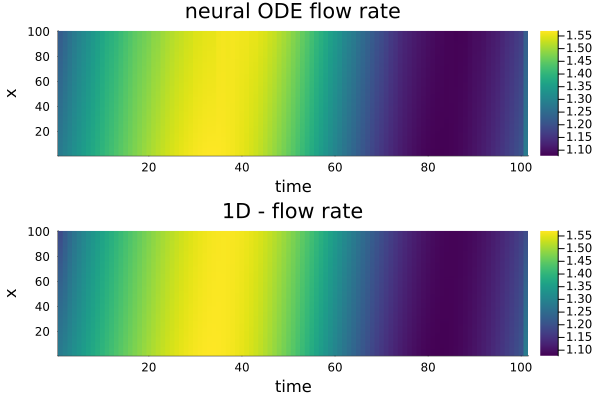

train 8


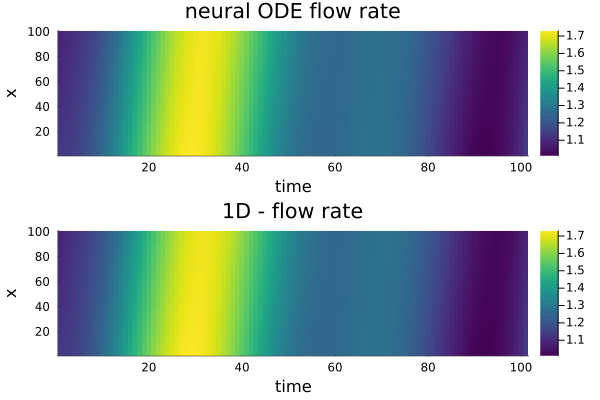

train 9


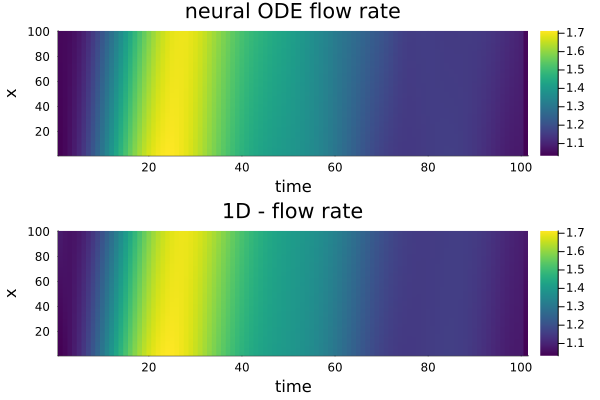

train 10


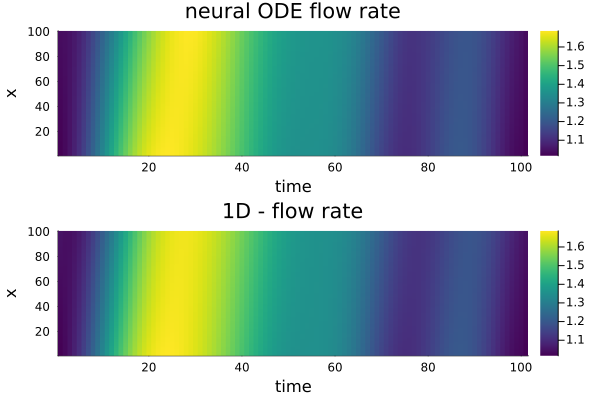

waveform batch: 2/3
rel train error batch:0.003330646040712176
train 1


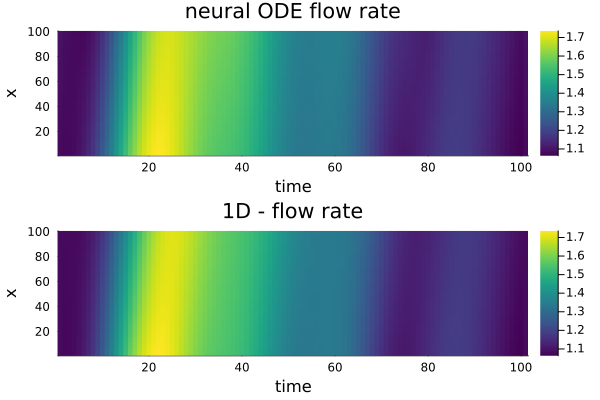

train 2


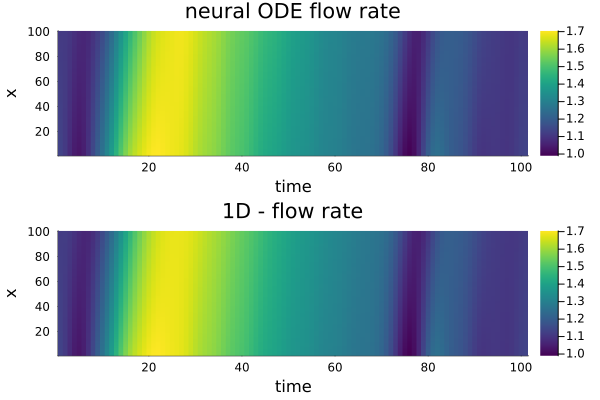

train 3


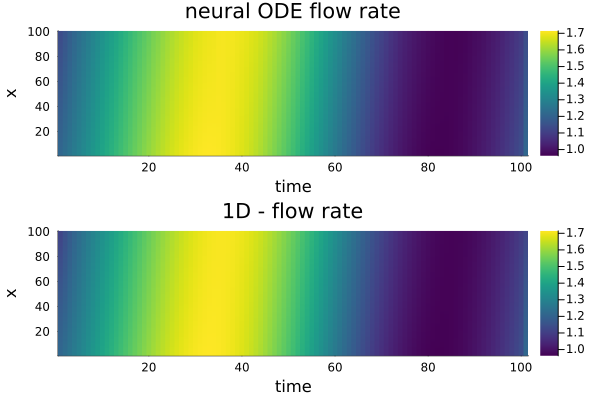

train 4


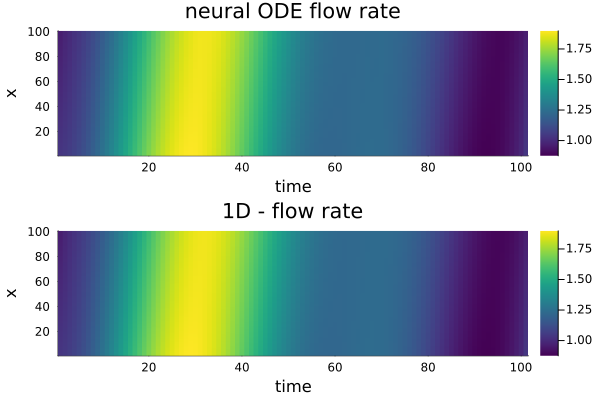

train 5


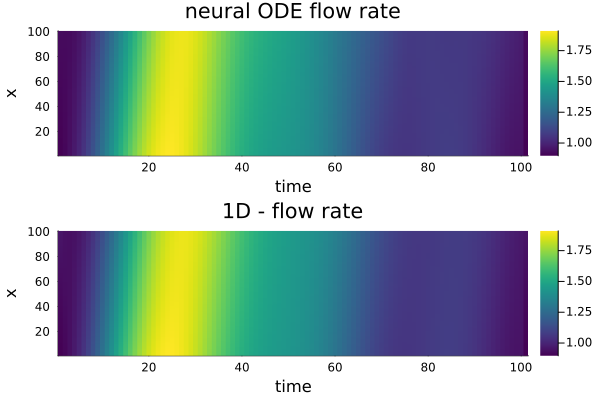

train 6


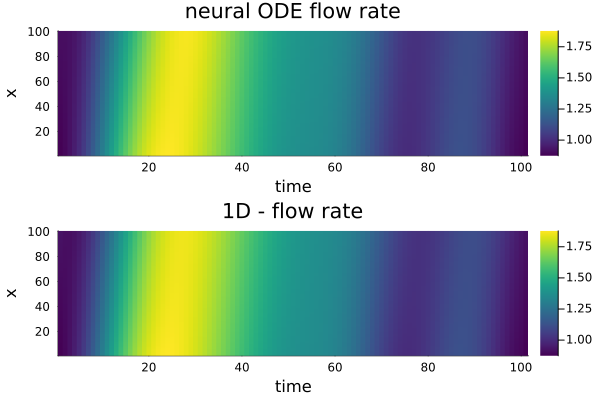

train 7


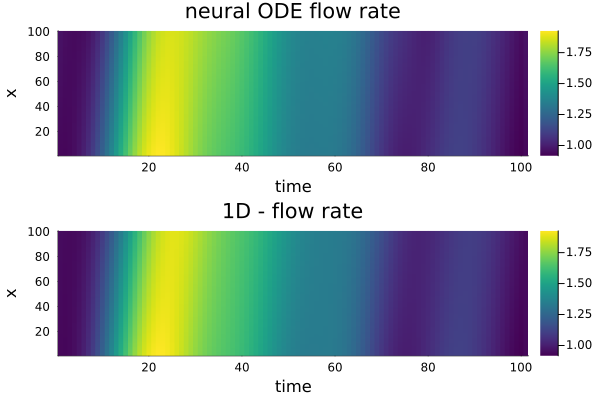

train 8


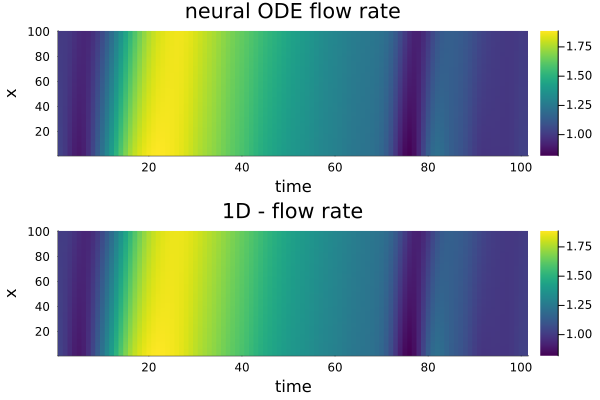

train 9


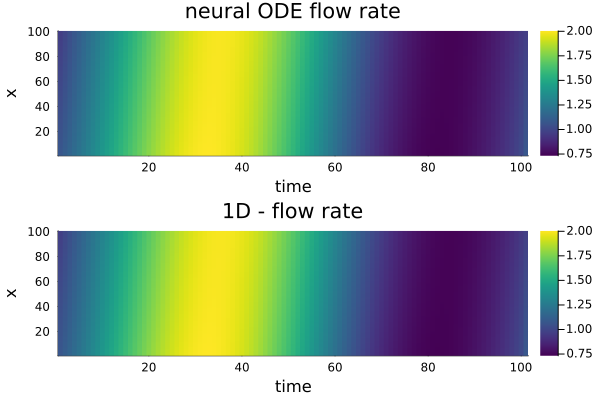

train 10


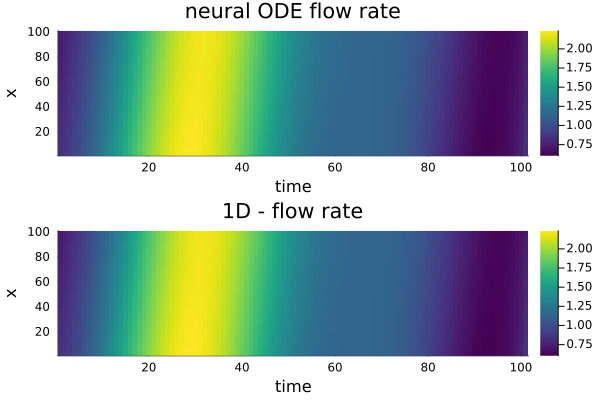

waveform batch: 3/3
rel train error batch:0.0058884274659355435
train 1


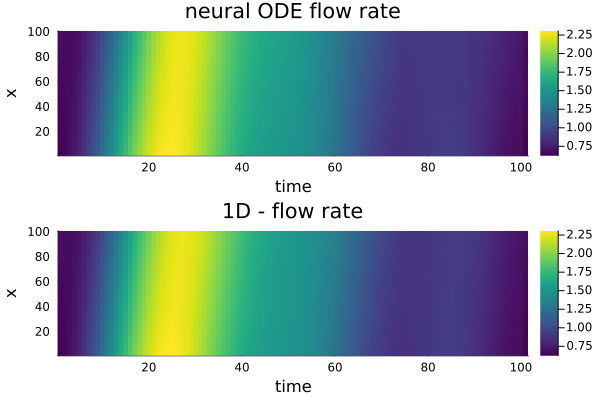

train 2


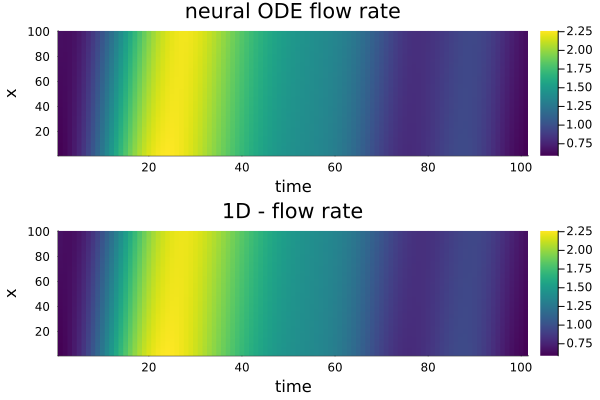

train 3


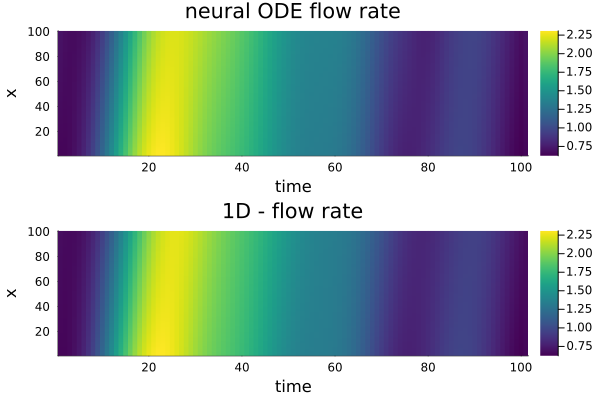

train 4


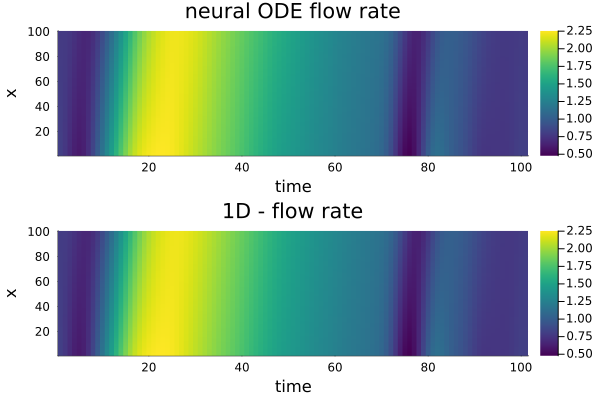

train 5


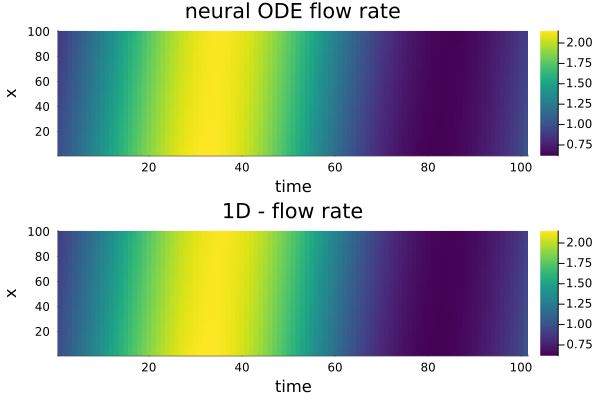

train 6


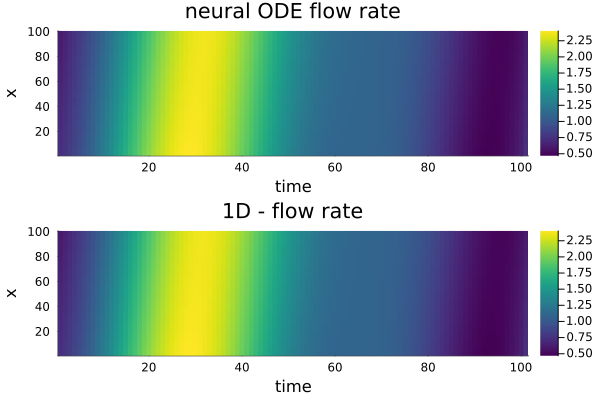

train 7


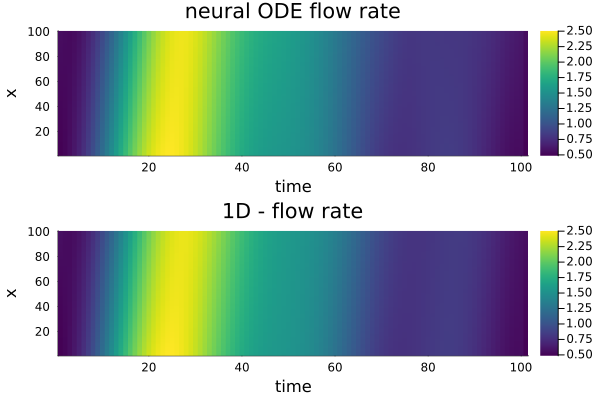

train 8


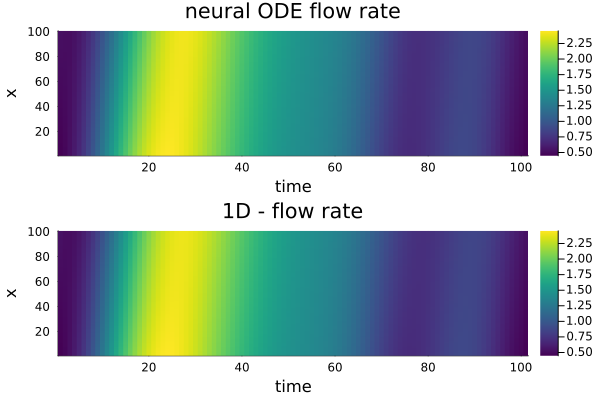

train 9


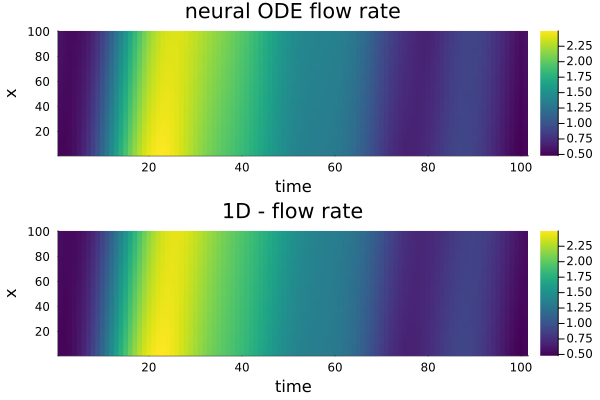

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing - extrapolation:
waveform batch: 1/2
rel test extrapolation error batch:0.006589598802154331
Test loss - extrapolation:8.609458056562769
extrapolation 1


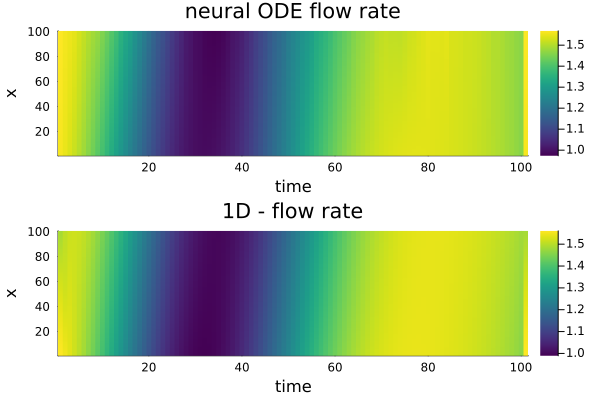

extrapolation 2


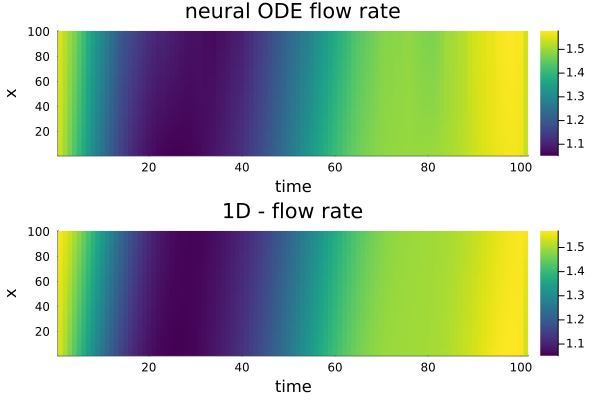

extrapolation 3


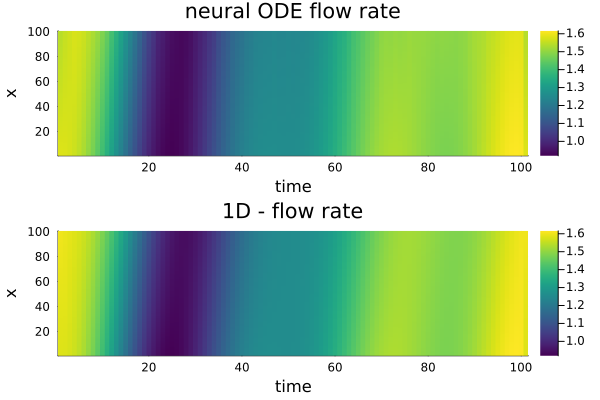

extrapolation 4


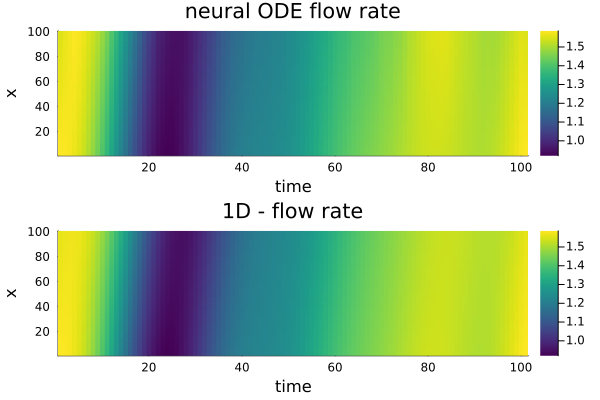

extrapolation 5


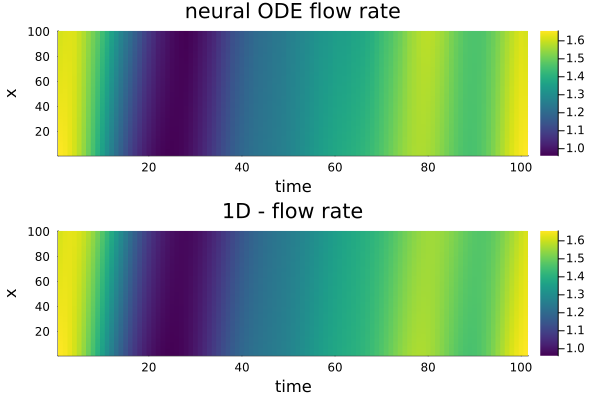

extrapolation 6


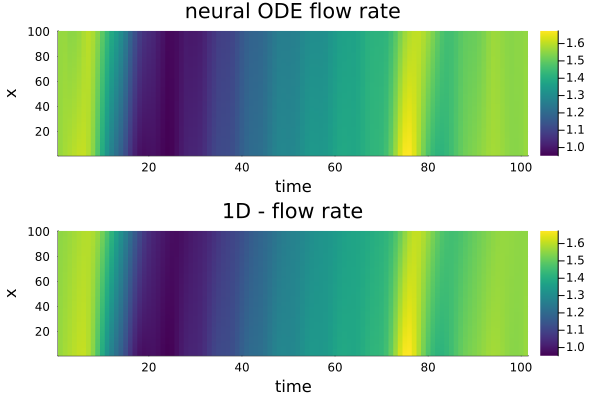

extrapolation 7


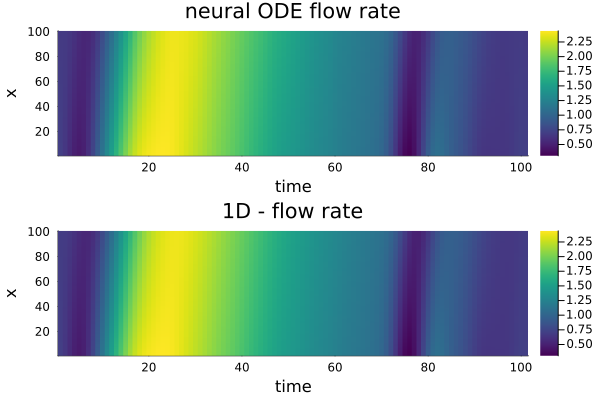

extrapolation 8


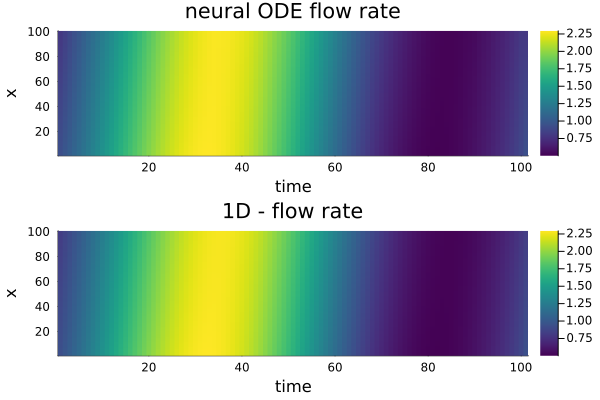

extrapolation 9


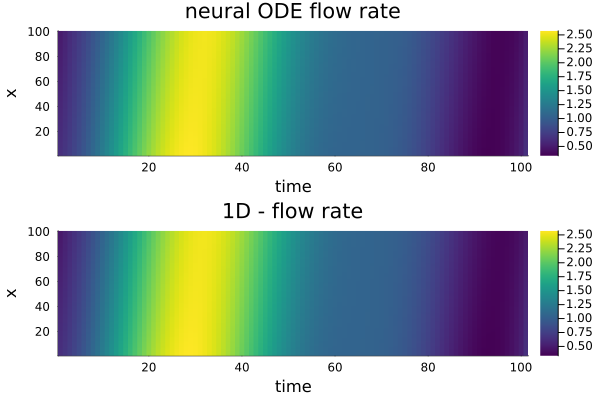

extrapolation 10


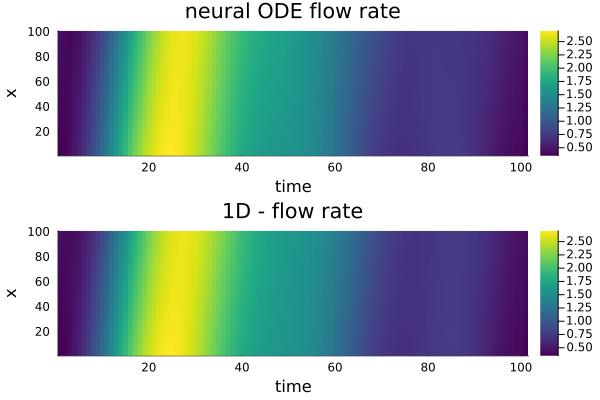

waveform batch: 2/2
rel test extrapolation error batch:0.007139988016462731
Test loss - extrapolation:2.3049119981580706
extrapolation 1


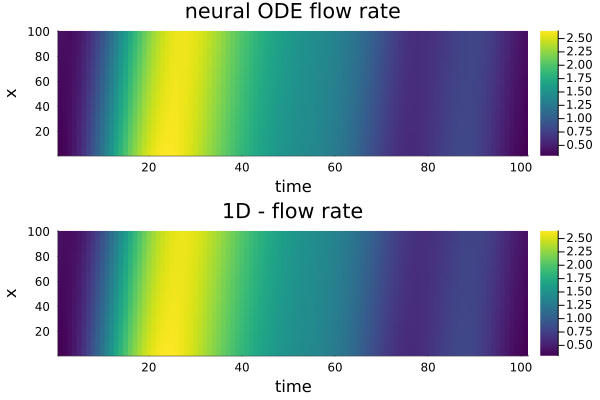

extrapolation 2


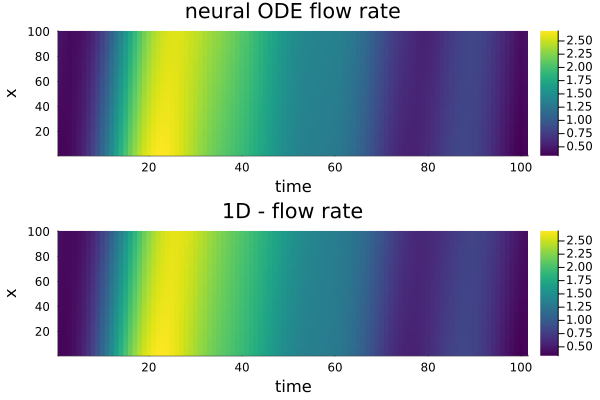

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Testing - interpolation:
waveform batch: 1/1
rel test interpolation error batch:0.004159674739881217
Test loss - interpolation:2.003167096815266
interpolation 1


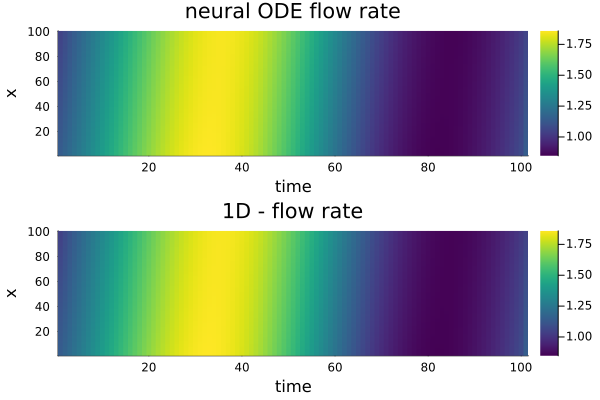

interpolation 2


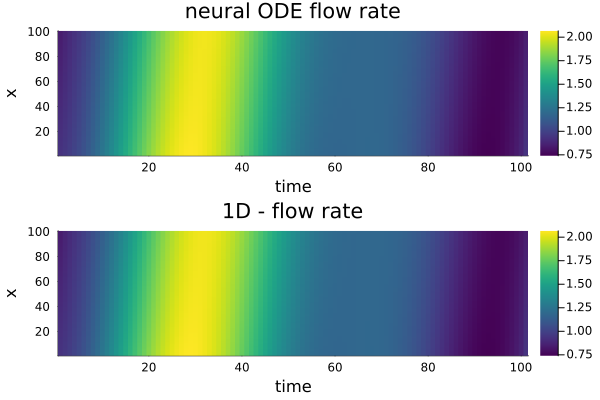

interpolation 3


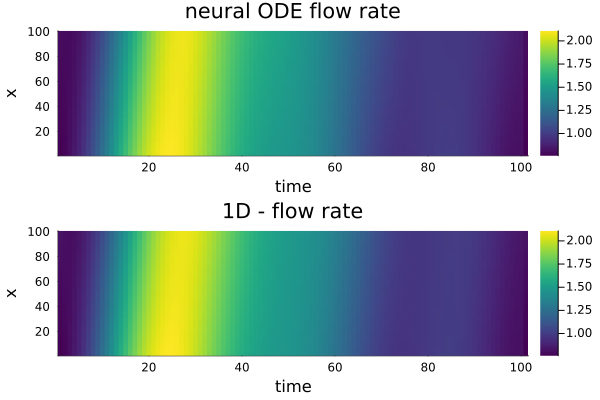

interpolation 4


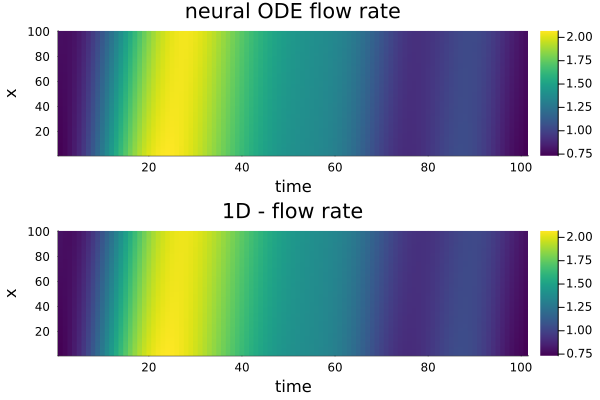

interpolation 5


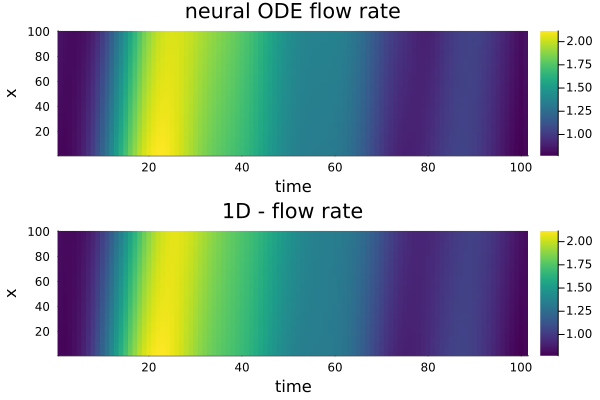

interpolation 6


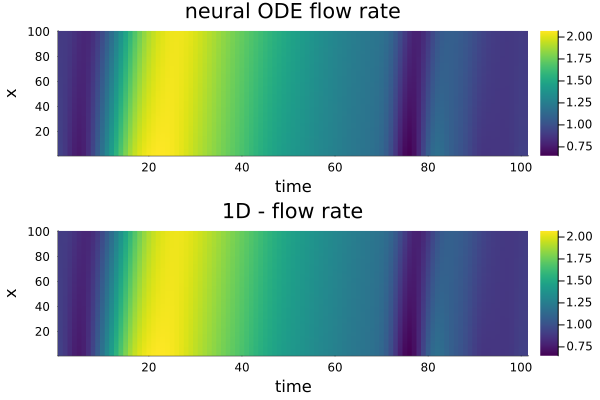

mean train loss:0.37642792881869563
mean test loss - interpolation:0.33386118280254434
mean test loss - extrapolation:0.9095308378934033


In [114]:
list_loss_train = []
list_loss_epoch = []
list_loss_test = []
list_loss_epoch_test = []
list_loss_ex = []
list_loss_epoch_ex = []

loss_tot = 0.0
loss_tot_test = 0.0
loss_tot_ex = 0.0

rel_err = 0.0
rel_err_test = 0.0
rel_err_ex = 0.0
#load learnt parameters from file
p_learn = load("/home/tschala/research/LANL/trained_models/dQdz_1/ptrained_BFGS.jld2")
p = p_learn["p"]
# loop over different waveforms
for i in 1:batch_iterations

    println("waveform batch: ",i, "/",batch_iterations)
    flush(stdout)
    #reorder ytrain, atrain and dAdz to [time, batch_size, spatial location]
    # batch size should be second column

    #reorder ytrain to (spatial location, batch_size, time)
    if i!=batch_iterations
        ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
        atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
        dadztrain = permutedims(dAdz[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
    else
        ytrain = permutedims(ytrain2[:,:,batch_size*(i-1)+1:end],(1,3,2))
        atrain = permutedims(Atrain[:,:,batch_size*(i-1)+1:end],(1,3,2))
        dadztrain = permutedims(dAdz[:,:,batch_size*(i-1)+1:end],(1,3,2))
    end



    #define function for interpolating area and dA/dz to the actual spatial location for the ODE
    interp_func(z) = interpolate_variables(z, atrain)
    dadz_interp_func(z) = interpolate_variables(z, dadztrain)


    #calculate final loss and push it to the list
    prob = ODEProblem((u, p, z) -> learn_1DBlood(u, p, z, interp_func,dadz_interp_func), ytrain[:,:,1], zspan, p);
    l , pred = loss(p,ytrain[:,:,:],prob)
    loss_tot = loss_tot + l
    
    println("rel train error batch:", norm(pred-ytrain) ./ norm(ytrain))
    
    push!(list_loss_train, l)

    for k in 1:size(pred)[2]
        # plot solution for comparison
        println("train ", k)
        # plot solution for comparison
        plot1 = heatmap(pred[:,k,:]', color=:viridis, title = "neural ODE flow rate")
        xlabel!("time")
        ylabel!("x")

        plot2 = heatmap(ytrain[:,k,:]', title="1D - flow rate", color=:viridis)
        xlabel!("time")
        ylabel!("x")
        display(plot(plot1,plot2,layout = (2, 1)))
        sleep(1)
    end

end    

#testing loop - extrapolation
println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
println("Testing - extrapolation:")

for i in 1:ex_batch_iterations

    println("waveform batch: ",i, "/",ex_batch_iterations)

    #reorder ytrain to (spatial location, batch_size, time)
    if i!=ex_batch_iterations
        yex = permutedims(yex2[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
        aex = permutedims(Aex[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
        dadzex = permutedims(dAdz_ex[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
    else
        yex = permutedims(yex2[:,:,batch_size*(i-1)+1:end],(1,3,2))
        aex = permutedims(Aex[:,:,batch_size*(i-1)+1:end],(1,3,2))
        dadzex = permutedims(dAdz_ex[:,:,batch_size*(i-1)+1:end],(1,3,2))
    end


    #define function for interpolating area and dA/dz to the actual spatial location for the ODE
    interp_func(z) = interpolate_variables(z, aex)
    dadz_interp_func(z) = interpolate_variables(z, dadzex)


    #calculate final loss and push it to the list
    prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func,dadz_interp_func), yex[:,:,1], zspan, p);
    l , pred = loss(p,yex[:,:,:],prob)
    loss_tot_ex = loss_tot_ex + l
    
    println("rel test extrapolation error batch:", norm(pred-yex) ./ norm(yex))
    
    push!(list_loss_ex, l)
    println("Test loss - extrapolation:",l )

    for k in 1:size(pred)[2]
        # plot solution for comparison
        println("extrapolation ", k)
        # plot solution for comparison
        plot1 = heatmap(pred[:,k,:]', color=:viridis, title = "neural ODE flow rate")
        xlabel!("time")
        ylabel!("x")

        plot2 = heatmap(yex[:,k,:]', title="1D - flow rate", color=:viridis)
        xlabel!("time")
        ylabel!("x")
        display(plot(plot1,plot2,layout = (2, 1)))
        sleep(1)
    end
end

#testing loop - interpolation
println("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
println("Testing - interpolation:")

for i in 1:test_batch_iterations

    println("waveform batch: ",i, "/",test_batch_iterations)

    #reorder ytrain to (spatial location, batch_size, time)
    if i!=test_batch_iterations
        ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
        atest = permutedims(Atest[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
        dadztest = permutedims(dAdz_test[:,:,batch_size*(i-1)+1:batch_size*i],(1,3,2))
    else
        ytest = permutedims(ytest2[:,:,batch_size*(i-1)+1:end],(1,3,2))
        atest = permutedims(Atest[:,:,batch_size*(i-1)+1:end],(1,3,2))
        dadztest = permutedims(dAdz_test[:,:,batch_size*(i-1)+1:end],(1,3,2))
    end


    #define function for interpolating area and dA/dz to the actual spatial location for the ODE
    interp_func(z) = interpolate_variables(z, atest)
    dadz_interp_func(z) = interpolate_variables(z, dadztest)


    #calculate final loss and push it to the list
    prob = ODEProblem((u, p, t) -> learn_1DBlood(u, p, t, interp_func,dadz_interp_func), ytest[:,:,1], zspan, p);
    l , pred = loss(p,ytest[:,:,:],prob)
    loss_tot_test = loss_tot_test + l

    println("rel test interpolation error batch:", norm(pred-ytest) ./ norm(ytest))
    
    
    push!(list_loss_test, l)
    println("Test loss - interpolation:",l )
    for k in 1:size(pred)[2]
        # plot solution for comparison
        println("interpolation ", k)
        plot1 = heatmap(pred[:,k,:]', color=:viridis, title = "neural ODE flow rate")
        xlabel!("time")
        ylabel!("x")

        plot2 = heatmap(ytest[:,k,:]', title="1D - flow rate", color=:viridis)
        xlabel!("time")
        ylabel!("x")
        display(plot(plot1,plot2,layout = (2, 1)))
        sleep(1)
    end
end

push!(list_loss_epoch, loss_tot/(size(ytrain2,3)))
push!(list_loss_epoch_test, loss_tot_test/(size(ytest2,3)))
push!(list_loss_epoch_ex, loss_tot_ex/(size(yex2,3)))
println("mean train loss:", loss_tot/(size(ytrain2,3)))
println("mean test loss - interpolation:", loss_tot_test/(size(ytest2,3)))
println("mean test loss - extrapolation:", loss_tot_ex/(size(yex2,3)))

In [2]:
loss_data = CSV.read("/home/tschala/research/LANL/trained_models/dQdz_1/dQdz_pureNN_loss_output.csv", DataFrame);
loss_mat = Matrix(loss_data);

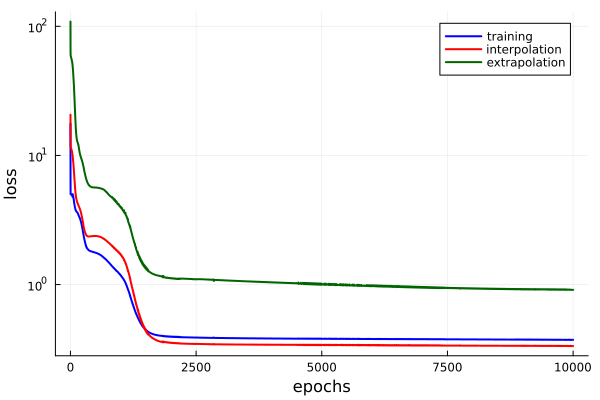

In [3]:
p1 = plot(loss_mat, yaxis=:log, label = ["training" "interpolation" "extrapolation"], linewidth = 2, color = ["blue" "red" "darkgreen"])
xlabel!("epochs")
ylabel!("loss")
png("/home/tschala/research/LANL/trained_models/dQdz_1/dQdz_pureNN_loss.png")
display(p1)